In [1]:
!nvidia-smi

Tue Nov  3 18:51:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 41%   36C    P2    68W / 280W |  13142MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:05:00.0 Off |                  N/A |
| 41%   34C    P8    22W / 280W |  16954MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
######### IMPORTING NECESSARY MODULES #########
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import torch.optim as optim

sys.path.append('/home/ironman/abhishek/Fixtures_Data/architectures/')
sys.path.append('/home/ironman/abhishek/Fixtures_Data/Helper/')
from dataloader import mydataset, create_prime_dict 
from ringloss import RingLoss
# from cutmix_rl_trainer import train, test_classify, eval_classify
from cutmix_rl_trainer_finetune import train, test_classify, eval_classify
from resnet_models import ResNet,Bottleneck
from Load_model import load
from plot_curves import plot_loss, plot_acc

from torch.utils.tensorboard import SummaryWriter

In [3]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:4


**Dataloading Scheme**

In [4]:
trainlist = 'Fixtures_Data_manual_clean_new_training_list_toys.txt'
validlist ='Fixtures_Data_manual_clean_new_validation_list_toys.txt'

In [5]:
prime_dict = create_prime_dict(trainlist)

Number of classes =  3323


In [6]:
#### Train Dataloader #### 
train_dataset = mydataset(trainlist, prime_dict, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 256, num_workers=16,pin_memory=True)


#### Validation Dataloader #### 
validation_dataset = mydataset(validlist, prime_dict, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 128, num_workers=16,pin_memory=True)

**Model Definition**

In [7]:
# Load Aliproducts model
model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes = 50030)
Alipro_modelpath = '/home/ironman/abhishek/saved_model_checkpoints/AliProducts/NewData_Apro_AA_Cutout_R50'

checkpoint = torch.load(Alipro_modelpath)
model = nn.DataParallel(model,device_ids=[4,5]).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [8]:
# Transfer Learning

for param in model.module.parameters():
    param.requires_grad = False

fc_inputs = model.module.fc.in_features

model.module.fc = nn.Sequential(
    nn.Linear(fc_inputs, 8192),
    nn.BatchNorm1d(8192),
    nn.ReLU(),
    nn.Linear(8192, 4096),
    nn.BatchNorm1d(4096),
    nn.ReLU(),

    nn.Linear(4096, 3323)
    
)

model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

**Hyperparameters**

In [9]:
## Loss Function
criterion = nn.CrossEntropyLoss()

ringloss_block = RingLoss(device,loss_weight=1.0)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 50, gamma = 0.1)

# Epochs
num_Epochs = 90

beta=1

cutmix_prob = 1

In [10]:
modelpath = '/home/ironman/abhishek/saved_model_checkpoints/Fixture_Data/Manually_cleaned_Finetune_double_Alipro_R50'

In [11]:
train(model, train_dataloader, validation_dataloader, beta, cutmix_prob, criterion, optimizer, lr_scheduler,
      ringloss_block, modelpath, device, epochs = num_Epochs)

loss 8.073574709892274
loss 15.872599225044251
loss 23.439790377616884
loss 30.80205900669098
loss 37.96034022808075
loss 44.96347377777099
loss 51.82226254463196
loss 58.454838285446165
loss 64.92220569133758
loss 71.27246519088744
loss 77.46326097488404
loss 83.61159642219543
Epoch:  1
training loss =  6.915267310812951
Validation Loss: 4.7795	Top 1 Validation Accuracy: 0.5220	 Top 5 Validation Accuracy: 0.6603
loss 5.844483652114868
loss 11.524665307998657
loss 17.124636397361755
loss 22.661770293712618
loss 28.044819242954254
loss 33.421898798942564
loss 38.626892812252045
loss 43.72073516845703
loss 48.747885766029356
loss 53.5936963558197
loss 58.45348906517029
loss 63.22467334508896
Epoch:  2
training loss =  5.243390184066495
Validation Loss: 3.0942	Top 1 Validation Accuracy: 0.6532	 Top 5 Validation Accuracy: 0.7727
loss 4.702111878395081
loss 9.246835906505584
loss 13.875259323120117
loss 18.376326861381532
loss 22.791378953456878
loss 27.28494162321091
loss 31.56749558925628

loss 27.343118352890016
Epoch:  20
training loss =  2.282196737107884
Validation Loss: 0.8339	Top 1 Validation Accuracy: 0.8487	 Top 5 Validation Accuracy: 0.9389
loss 2.319910607933998
loss 4.581218225955963
loss 6.852391994595528
loss 9.045058425664902
loss 11.293805727958679
loss 13.592682852745057
loss 15.919945266246796
loss 18.103598771691324
loss 20.388135632872583
loss 22.73068422794342
loss 25.038086718320848
loss 27.31033050954342
Epoch:  21
training loss =  2.273227841980273
Validation Loss: 0.8212	Top 1 Validation Accuracy: 0.8499	 Top 5 Validation Accuracy: 0.9396
loss 2.2368741142749786
loss 4.530278367996216
loss 6.858223783969879
loss 9.083074848651886
loss 11.331419309973716
loss 13.585749180912972
loss 15.870764978528022
loss 18.164743458032607
loss 20.368300741910936
loss 22.560588285923004
loss 24.772371563315392
loss 27.020054131746292
Epoch:  22
training loss =  2.251355803549572
Validation Loss: 0.8104	Top 1 Validation Accuracy: 0.8506	 Top 5 Validation Accuracy:

Validation Loss: 0.7244	Top 1 Validation Accuracy: 0.8602	 Top 5 Validation Accuracy: 0.9498
loss 1.9945358991622926
loss 4.04538870036602
loss 6.088074154853821
loss 8.091167633533479
loss 10.072069301009178
loss 12.05456461071968
loss 14.059249851703644
loss 16.07551429986954
loss 18.06863110423088
loss 20.098067365288735
loss 22.089041035175324
loss 24.11376310288906
Epoch:  41
training loss =  2.0070916585635987
Validation Loss: 0.7208	Top 1 Validation Accuracy: 0.8612	 Top 5 Validation Accuracy: 0.9499
loss 1.9312361288070679
loss 3.934794241786003
loss 5.945952891111374
loss 7.935334197282791
loss 9.936102153062821
loss 11.933044794201852
loss 14.01134498476982
loss 16.02126316010952
loss 18.03140011191368
loss 20.046362801194192
loss 22.002521035075187
loss 24.025780984163283
Epoch:  42
training loss =  2.001455657101732
Validation Loss: 0.7196	Top 1 Validation Accuracy: 0.8598	 Top 5 Validation Accuracy: 0.9505
loss 2.0384972214698793
loss 4.04684484064579
loss 6.13218662679195

loss 11.49284207046032
loss 13.416229590177537
loss 15.368989692926407
loss 17.21315357744694
loss 19.13116448521614
loss 20.995218270421027
loss 22.89601797223091
Epoch:  60
training loss =  1.9090907819463179
Validation Loss: 0.6982	Top 1 Validation Accuracy: 0.8628	 Top 5 Validation Accuracy: 0.9526
loss 1.9077753329277038
loss 3.7996669805049894
loss 5.71670166194439
loss 7.612849715352058
loss 9.575093692541122
loss 11.576109154820442
loss 13.556076000332832
loss 15.527680100798607
loss 17.50457964837551
loss 19.48213955104351
loss 21.508244447112084
loss 23.464793455600738
Epoch:  61
training loss =  1.9534996377913307
Validation Loss: 0.6992	Top 1 Validation Accuracy: 0.8630	 Top 5 Validation Accuracy: 0.9525
loss 1.908423056602478
loss 3.8509784072637556
loss 5.805214334130287
loss 7.707063171863556
loss 9.613208364844322
loss 11.52855273425579
loss 13.463510064482689
loss 15.337685131430625
loss 17.181801598072052
loss 19.102428879737854
loss 21.033276928663255
loss 22.9139508

Validation Loss: 0.6956	Top 1 Validation Accuracy: 0.8635	 Top 5 Validation Accuracy: 0.9529
loss 1.9256510746479034
loss 3.8309065574407577
loss 5.801382337212562
loss 7.754831080436706
loss 9.603828343749047
loss 11.481299913525582
loss 13.375983276367187
loss 15.30259774506092
loss 17.18080713033676
loss 19.13575995147228
loss 21.047188440561296
loss 22.960208723545076
Epoch:  80
training loss =  1.9111376913002505
Validation Loss: 0.6937	Top 1 Validation Accuracy: 0.8639	 Top 5 Validation Accuracy: 0.9532
loss 1.9332348388433456
loss 3.7872007220983503
loss 5.694819626808166
loss 7.647210896611214
loss 9.568041732907295
loss 11.448711128234864
loss 13.343061619997025
loss 15.259511289596558
loss 17.19755579352379
loss 19.076412621736527
loss 20.934457169175147
loss 22.784985146522523
Epoch:  81
training loss =  1.8994114463457377
Validation Loss: 0.6944	Top 1 Validation Accuracy: 0.8635	 Top 5 Validation Accuracy: 0.9531
loss 1.9192858761548997
loss 3.8188290929794313
loss 5.694324

In [10]:
#### Load saved model from checkpoint  #####
model, optimizer, lr_scheduler, train_loss, v_loss, v_acc, epoch = load(modelpath, model, optimizer, lr_scheduler)


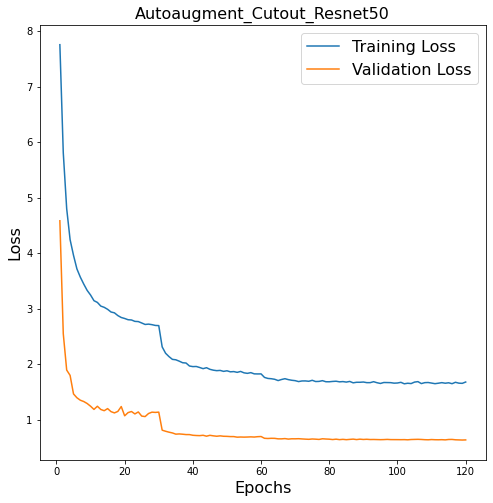

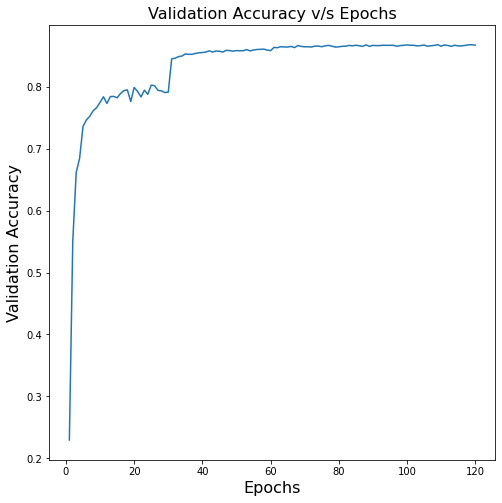

In [11]:
#### Plot Loss Curves ####
plot_loss(epoch, train_loss, v_loss, title = 'Autoaugment_Cutout_Resnet50')
plot_acc(epoch, v_acc)

In [20]:
t_loss,top1_t_acc, top5_t_acc =test_classify(model, train_dataloader, criterion, device)
print('Training Loss: {:.4f}\tTop 1 Training Accuracy: {:.4f}\t Top 5 Training Accuracy: {:.4f}'.format(t_loss, top1_t_acc, top5_t_acc))

Training Loss: 0.4860	Top 1 Training Accuracy: 0.8849	 Top 5 Training Accuracy: 0.9747


In [13]:
v_loss, top1_acc, accuracy_dict= eval_classify(model, validation_dataloader, criterion, device)
print('Validation Loss: {:.4f}\tTop 1 Validation Accuracy: {:.4f}\nAccuracy:{}\t'.format(v_loss, top1_acc, accuracy_dict))

Validation Loss: 0.6382	Top 1 Validation Accuracy: 0.8663
Accuracy:defaultdict(<class 'int'>, {'Top 1 Accuracy': 86.62588180194948, 'Top 5 Accuracy': 95.84345637092761, 'Top 10 Accuracy': 97.03187659163423, 'Top 20 Accuracy': 97.89538389485702, 'Top 30 Accuracy': 98.23785967274536, 'Top 50 Accuracy': 98.57448116383222, 'Top 100 Accuracy': 99.02526124754851})	
